In [1]:
#import modules
%pylab inline

from astropy.cosmology import Planck13
from astropy.io import fits
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra,restore_qso_grid
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
random.seed(12345)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

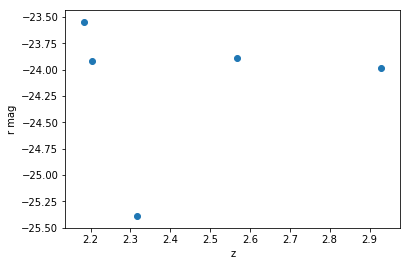

In [3]:
# randomly assigning magnitude and redshift points
nqso = 5 #number of quasars
zin = 2.0 + np.random.rand(nqso)
# fixed magnitude and redshift points
#M = AbsMagVar(FixedSampler(linspace(-27,-25,nqso)[::-1]),restWave=1450)
#z = RedshiftVar(FixedSampler(linspace(2,4,nqso)))
#qsos = QsoSimPoints([M,z],cosmo=Planck13,units='luminosity')
kcorr = sqbase.ContinuumKCorr('DECam-r',1450,effWaveBand='SDSS-r')
qsos = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=Planck13),
                         (15,23),(2.0,3.0),
                        kcorr=kcorr,zin=zin,
                         qlfseed=12345,gridseed=67890)
scatter(qsos.z,qsos.absMag)
xlabel('z')
ylabel('r mag');


In [4]:
sedVars = get_BossDr9_model_vars(qsos,wave,0,forestseed=192837465,verbose=1)
qsos.addVars(sedVars)

Generating 5 sightlines


In [5]:
# add two dust components as in Lyu+Rieke 2017, but reduce the hot dust flux by a factor of 2
#contVar = BrokenPowerLawContinuumVar([GaussianSampler(-1.5,0.3),
#                                      GaussianSampler(-0.5,0.3)],
#                                    [1215.])

#subDustVar = DustBlackbodyVar([ConstSampler(0.05),ConstSampler(1800.)],
#                               name='sublimdust')
#subDustVar.set_associated_var(contVar)
#hotDustVar = DustBlackbodyVar([ConstSampler(0.1),ConstSampler(880.)],
#                               name='hotdust')
#hotDustVar.set_associated_var(contVar)


In [6]:
# generate lines using the Baldwin Effect emission line model from BOSS DR9
#emLineVar = generateBEffEmissionLines(qsos.absMag)

In [7]:
# the default iron template from Vestergaard & Wilkes 2001 was modified to fit BOSS spectra
#fescales = [(0,1540,0.5),(1540,1680,2.0),(1680,1868,1.6),(1868,2140,1.0),(2140,3500,1.0)]
#feVar = FeTemplateVar(VW01FeTemplateGrid(qsos.z,wave,scales=fescales))

In [8]:
# Now add the features to the QSO grid
#qsos.addVars(contVar)
#qsos.addVars(subDustVar)
#qsos.addVars(hotDustVar)
#qsos.addVars(emLineVar)
#qsos.addVars(feVar)

Simulation of n number of Quasars

In [9]:
# simulation
qsos.loadPhotoMap([('DECam','DECaLS'),('WISE','AllWISE')])
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=20)

simulating  5  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.1715631, rms = 0.0937316, |max| = 0.3001571
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0124708, rms = 0.0149980, |max| = 0.0409284
buildSpectra iteration  3  out of  3
--> delta mag mean = -0.0003663, rms = 0.0006200, |max| = 0.0015952


In [10]:
# data set
qsos.data

absMag,appMag,z,slopes [5],"emLines [62,3]",igmlos,synMag [5],synFlux [5]
float32,float32,float32,float32,float32,int32,float32,float32
-23.643517,21.501194,2.929616,-1.1090124 .. -1.3522637,1033.9022 .. 237.50203,0,21.84052 .. 20.264404,1.8356565 .. 7.8385916
-25.184532,19.570347,2.3163755,-1.7876623 .. -1.4094697,1033.4984 .. 258.0555,1,19.52986 .. 18.037594,15.419006 .. 60.948406
-23.450861,21.284784,2.1839187,-1.4972172 .. -1.3374733,1034.3695 .. 298.65213,2,21.159777 .. 19.722197,3.436285 .. 12.91581
-23.87834,20.931494,2.2045603,-0.99838966 .. -1.0632886,1033.9122 .. 249.62062,3,20.786741 .. 19.78734,4.845112 .. 12.16364
-23.650661,21.308784,2.567725,-1.2061319 .. -0.70490855,1034.1293 .. 289.31863,4,21.321766 .. 20.56323,2.9600148 .. 5.9526105


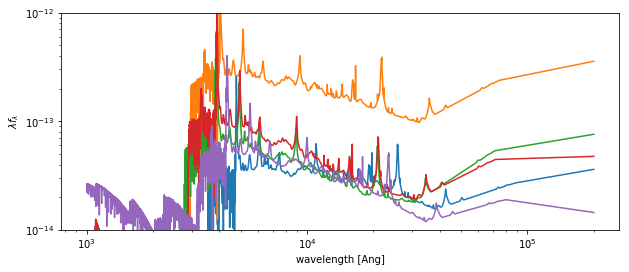

In [11]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

(3000, 5500)

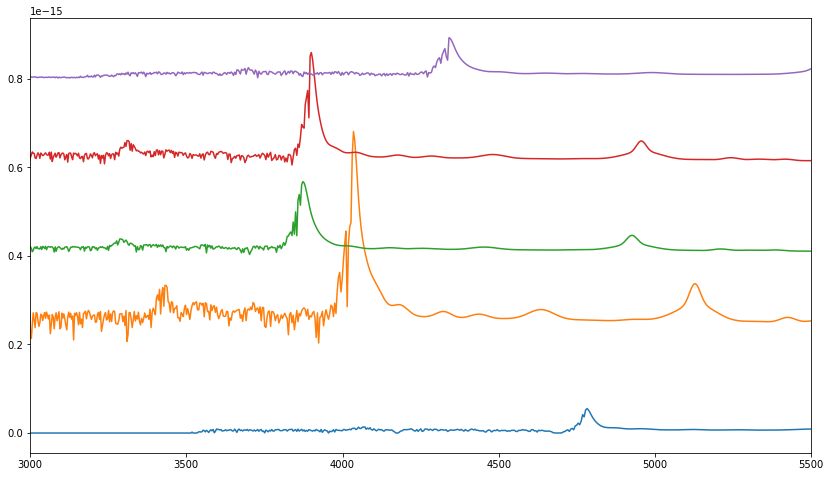

In [12]:
figure(figsize=(14,8))
for i,sp in enumerate(spectra):
    plot(wave,sp+i*2e-16)
xlim(3000,5500)

In [13]:
# compare the resulting SEDs to the mean SED from Lyu+Rieke 2017
from astropy.table import Table
try:
    lr17 = Table.read('apjaa7051t4_mrt.txt',format='ascii')
    lr17wave = array(10**lr17['lambda'])
    lamflam = array(spectra)*wave
    figure(figsize=(8,4))
    for i,z in enumerate(qsos.data['z']):
        j = searchsorted(wave/(1+z),5100)
        fscl = 1/lamflam[i,j]
        plot(wave/(1+z)/1e4,log10(fscl*lamflam[i]))
    j = searchsorted(lr17wave,0.51)
    fscl = lr17['LogL-Norm'][j]
    plot(lr17wave,lr17['LogL-Norm']-fscl,c='k')
    axvline(0.51,c='gray',ls='--')
    xlim(0.1,5)
    ylim(-1,1)
    xscale('log');
except IOError:
    pass

Divide the spectrum into components. Offset the emission line and iron template features for clarity.

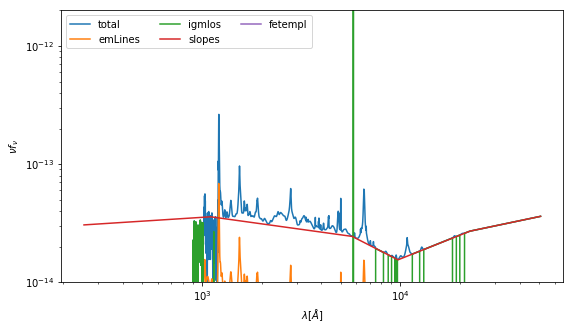

In [14]:
sp,comp = buildQsoSpectrum(wave,qsos.cosmo,qsos.getVars(SpectralFeatureVar),
                           qsos.data[0],save_components=True)
z1 = sp.z + 1
figure(figsize=(9,5))
plot(sp.wave/z1,sp.wave*sp.f_lambda,label='total')
for cname,cspec in comp.items():
    flam = cspec.f_lambda
    if cname in ['emLines','fetempl']:
        flam = 0.25*comp['slopes'].f_lambda*(1+flam)
    plot(cspec.wave/z1,cspec.wave*flam,label=cname)
legend(ncol=3)
ylim(1e-14,2e-12)
xscale('log')
yscale('log')
xlabel('$\lambda [\AA]$')
ylabel(r'$\nu{f}_\nu$');

In [15]:
qsos.write('quasar1_meta',extname='quasar1',overwrite=True)

In [16]:
ff = fits.open('quasar1_meta.fits')
ff.info()

Filename: quasar1_meta.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  QUASAR1       1 BinTableHDU     66   5R x 8C   [E, E, E, 5E, 186E, J, 5E, 5E]   


In [17]:
save_spectra(wave,spectra,'quasar1')

In [18]:
wave,spec = load_spectra('quasar1')

In [19]:
qsos_restore = restore_qso_grid('quasar1_meta',wave,extname='quasar1')

In [20]:
specs0 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[0])

absMag,appMag,z,slopes [5],"emLines [62,3]",igmlos,synMag [5],synFlux [5]
float32,float32,float32,float32,float32,int32,float32,float32
-23.643517,21.501194,2.929616,-1.1090124 .. -1.3522637,1033.9022 .. 237.50203,0,21.84052 .. 20.264404,1.8356565 .. 7.8385916


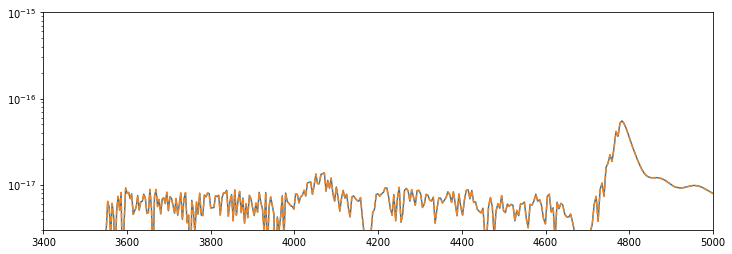

In [21]:
figure(figsize=(12,4))
plot(wave,spectra[0],lw=1.4)
plot(wave,specs0.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-16)
xlim(3400,5000);#1e4);
qsos.data[0]

In [22]:
spec1 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[1])

absMag,appMag,z,slopes [5],"emLines [62,3]",igmlos,synMag [5],synFlux [5]
float32,float32,float32,float32,float32,int32,float32,float32
-25.184532,19.570347,2.3163755,-1.7876623 .. -1.4094697,1033.4984 .. 258.0555,1,19.52986 .. 18.037594,15.419006 .. 60.948406


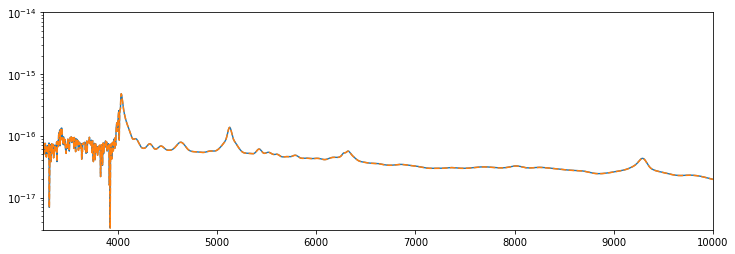

In [23]:
figure(figsize=(12,4))
plot(wave,spectra[1],lw=1.4)
plot(wave,spec1.f_lambda,ls='--')
yscale('log')
ylim(3e-18,10e-15)
xlim(3250,1e4);
qsos.data[1]

In [24]:
_,allspec = buildSpectraBulk(wave,qsos_restore)

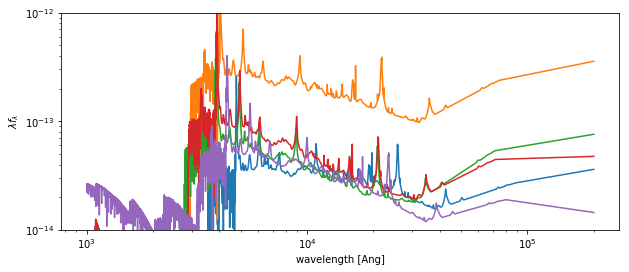

In [25]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$')
ylim(1e-14,1e-12);

In [26]:
spec2 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[2])

absMag,appMag,z,slopes [5],"emLines [62,3]",igmlos,synMag [5],synFlux [5]
float32,float32,float32,float32,float32,int32,float32,float32
-23.450861,21.284784,2.1839187,-1.4972172 .. -1.3374733,1034.3695 .. 298.65213,2,21.159777 .. 19.722197,3.436285 .. 12.91581


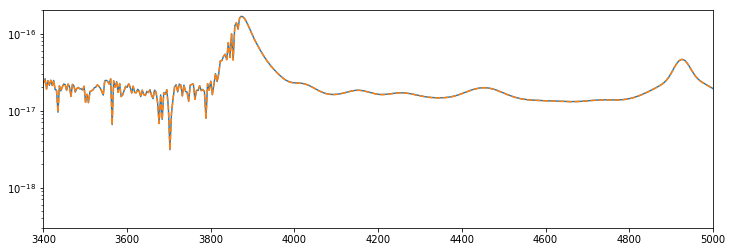

In [27]:
figure(figsize=(12,4))
plot(wave,spectra[2],lw=1.4)
plot(wave,spec2.f_lambda,ls='--')
yscale('log')
ylim(3e-19,2e-16)
xlim(3400,5000);#1e4);
qsos.data[2]

In [28]:
spec3 = buildQsoSpectrum(wave,qsos_restore.cosmo,
                         qsos_restore.getVars(SpectralFeatureVar),
                         qsos_restore.data[3])

absMag,appMag,z,slopes [5],"emLines [62,3]",igmlos,synMag [5],synFlux [5]
float32,float32,float32,float32,float32,int32,float32,float32
-23.87834,20.931494,2.2045603,-0.99838966 .. -1.0632886,1033.9122 .. 249.62062,3,20.786741 .. 19.78734,4.845112 .. 12.16364


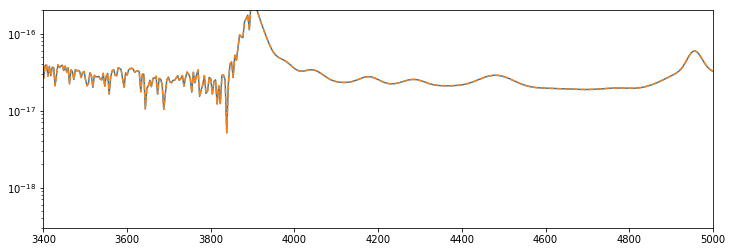

In [29]:
figure(figsize=(12,4))
plot(wave,spectra[3],lw=1.4)
plot(wave,spec3.f_lambda,ls='--')
yscale('log')
ylim(3e-19,2e-16)
xlim(3400,5000);#1e4);
qsos.data[3]